## LSTM for lag

- p5a: Copied from https://cmsdk.com/python/lstm--learn-a-simple-lag-in-the-data.html
- p5b: my fixes
- p5c: Use LSTM-based AE (i.e. no output, just unsupervised dimensionality reduction)

### below model results summary

with enc_dim=1 (using Dense layer):
-    loss reaches 0.70 in  50 epochs and slows down dramatically, prediction does not display lags

with enc_dim=None:
-    loss reaches 0.01 in 150 epochs, prediction displays lags

with enc_dim=10 (using Dense layer):
- Epoch 65/200: 6s - loss: 0.1557 - val_loss: 0.1536
  - predictions do not display lags
  
with enc_dim=10 (using LSTM layer):
- Epoch 107/200 - loss: 0.0772 - val_loss: 0.0786
  - 1st 2 predicted features display lag, 3rd feature still negligible
- Epoch 107+200/200 - loss: 0.0714 - val_loss: 0.0711
  - 1st 2 predicted features display lag, 3rd feature still negligible
  
add dropout
- Epoch 67/200 - loss: 0.1838 - val_loss: 0.1620
  - no visible correlations

To try
- with enc_dim != None,
  - try to pretrain without the intermediate stacked LSTM
  - then train with it
  - ref: https://stackoverflow.com/a/41661229/4126114
- change the optimizer from rmsprop to something else?
    - [nadam](https://keras.io/optimizers/) says something about adam and momentum.
    - note that the [keras docs](https://keras.io/getting-started/sequential-model-guide/) on stacked lstm just use rmsprop

In [1]:
# import os
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import keras
def strided_app(a, L, S ):  #To get X in the right format expected by Keras
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

import utils
import utils2

Using TensorFlow backend.


model (99998, 3)


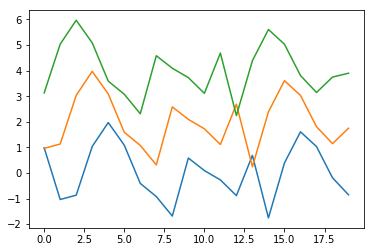

calib (99989, 10, 3)


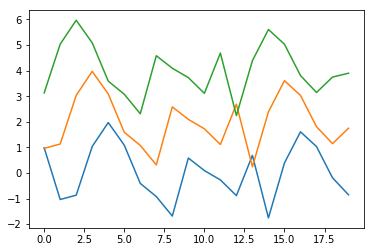

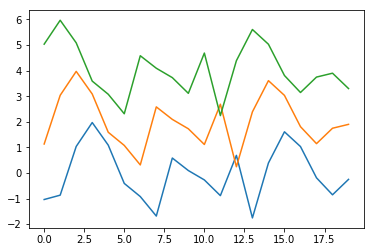

In [2]:
nb_samples = 100000
X = np.random.randn(nb_samples)
# generate data with 3-lag correlation: X(t-1), X(t), and X(t+1)
timesteps = 3

X_model = strided_app(X, timesteps, 1)
print('model', X_model.shape)
utils.myPlot(X_model[:20],2)

# The first striding above was done in order to generate the input data with a built-in lag relationship
# Now need to stride again because we need to pretend that we do not know that the input has this correlation
# Without this re-striding, it's like telling the model to get y=X
look_back = 10
X_calib      = utils2._load_data_strides(X_model,       n_prev=look_back)
print('calib', X_calib.shape)
utils.myPlot(X_calib[:20,0,:],2) # same as earlier plot
utils.myPlot(X_calib[:20,1,:],2) # lagged version of above plot

In [3]:
# SPLIT train/validation/test
nb_samples_calib = X_calib.shape[0]
nb_train = int(nb_samples_calib * 0.7)
nb_val = int(nb_samples_calib * 0.85)
# strided version
Xc_train = X_calib[: nb_train]
Xc_validation = X_calib[nb_train : nb_val]
Xc_test = X_calib[nb_val:]
# unstrided version
Xm_train = X_model[: nb_train]
Xm_validation = X_model[nb_train : nb_val]
Xm_test = X_model[nb_val:]

print('strided',   Xc_train.shape, Xc_validation.shape, Xc_test.shape)
print('unstrided', Xm_train.shape, Xm_validation.shape, Xm_test.shape)

strided (69992, 10, 3) (14998, 10, 3) (14999, 10, 3)
unstrided (69992, 3) (14998, 3) (15008, 3)


In [4]:
# Note 1: no dropout
# Note 2: add encoded dimension
# Using build_lstm_vanilla with enc_dim doesn't work as the output features cannot be lagged from each other
#    with enc_dim = 1, and no LSTM after enc_dim: until epoch=100, loss: 0.6737 - val_loss: 0.6645
#                                                 until epoch=200, loss: 0.6724 - val_loss: 0.6615
# model = utils2.build_lstm_vanilla(in_neurons=Xc_train.shape[2], out_neurons=Xm_train.shape[1], lstm_dim=20, enc_dim=1)

model = utils2.build_lstm_ae(in_neurons=Xc_train.shape[2], lstm_dim=20, look_back=look_back, enc_dim=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 20)          1920      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1240      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 10)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 20)            2480      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 3)             63        
Total params: 5,703
Trainable params: 5,703
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks=[]
#weights_path = 'weights.h5'
#early_stopping = EarlyStopping(monitor='val_loss',
#                           patience=100)
#checkpointer = ModelCheckpoint(filepath=weights_path,
#                           verbose=2,
#                           save_best_only=True)
#callbacks = [early_stopping, checkpointer]
history = model.fit(Xc_train,
                    Xc_train,#Xm_train, # the TimeDistributed in the model allows me to train again Xc instead of Xm
                    epochs = 200, # FIXME # 10000,
                    callbacks = callbacks,
                    verbose = 2,
                    # since stateless, make sure this is larger than the look-back=10 and the generated lag=3
                    batch_size = 500, # FIXME # 100
                    validation_data = (Xc_validation,
                                       Xc_validation),#Xm_validation),
                    shuffle = True)

Train on 69992 samples, validate on 14998 samples
Epoch 1/200
38s - loss: 0.1648 - val_loss: 0.1450
Epoch 2/200
37s - loss: 0.1641 - val_loss: 0.1416
Epoch 3/200
33s - loss: 0.1625 - val_loss: 0.1375
Epoch 4/200
34s - loss: 0.1613 - val_loss: 0.1401
Epoch 5/200
33s - loss: 0.1611 - val_loss: 0.1350
Epoch 6/200
33s - loss: 0.1597 - val_loss: 0.1433
Epoch 7/200
32s - loss: 0.1589 - val_loss: 0.1359
Epoch 8/200
35s - loss: 0.1580 - val_loss: 0.1346
Epoch 9/200
33s - loss: 0.1572 - val_loss: 0.1329
Epoch 10/200
34s - loss: 0.1564 - val_loss: 0.1357
Epoch 11/200
32s - loss: 0.1559 - val_loss: 0.1461
Epoch 12/200
44s - loss: 0.1552 - val_loss: 0.1272
Epoch 13/200


X (69992, 10, 3) Y (69992, 3) pred (69992, 10, 3)
reshaped pred (69992, 3)


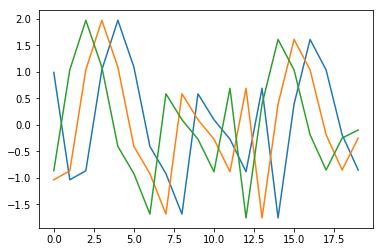

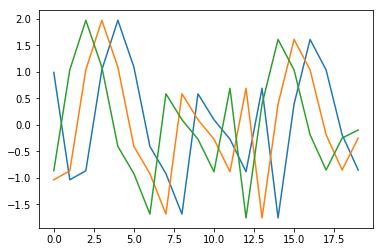

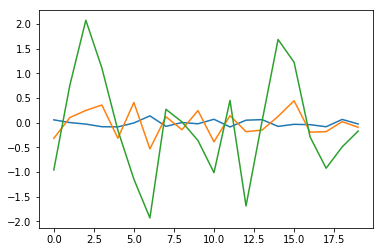

0.33526668408
X (14998, 10, 3) Y (14998, 3) pred (14998, 10, 3)
reshaped pred (14998, 3)


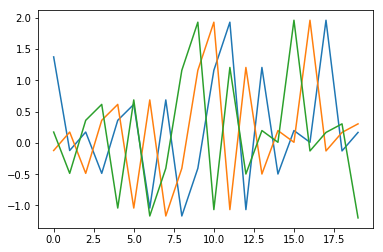

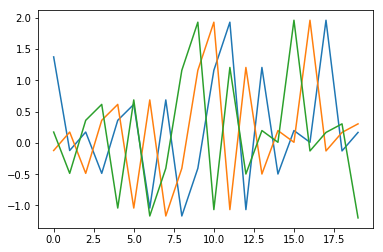

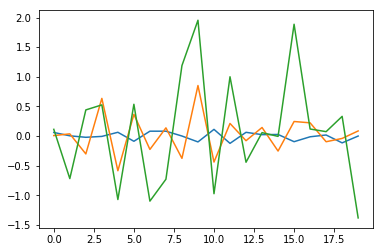

0.335377095842


In [8]:
from matplotlib import pyplot as plt
def myPlot(X):
    plt.plot(X)
    plt.show()

#def R2(X, Y, model):
#    Y_mean = np.mean(Y, axis=0)
#    pred = model.predict(X)
#    res = np.sum(np.square(Y - pred))
#    tot = np.sum(np.square(Y - Y_mean))
#    r2 = 1 - res / tot
#    return r2

def R2(X, Y, model):
    Y_mean = np.mean(Y, axis=0)
    pred = model.predict(X)
    print('X', X.shape, 'Y', Y.shape, 'pred', pred.shape)
    #pred = pred.reshape(Y.shape[0])
    pred = pred[:,0,:]
    print('reshaped pred', pred.shape)
    res = np.sum(np.square(Y - pred))
    tot = np.sum(np.square(Y - Y_mean))
    r2 = 1 - res / tot
    myPlot(X[:20,0])
    myPlot(Y[:20])
    myPlot(pred[:20])
    return r2

#model.load_weights(weights_path)
print(R2(Xc_train,      Xm_train,      model))
print(R2(Xc_validation, Xm_validation, model))
# some dimensionality problems
# print(R2(Xc_test,       Xm_test,       model))

In [ ]:
# check encoded signal: expect detection of 1 of the lagged features in X
from keras.models import Model
lstm_enc = Model(inputs=model.input, outputs=model.layers[1].output)
lstm_enc.compile(loss="mean_squared_error", optimizer="rmsprop")
lstm_enc.summary()

X_enc = lstm_enc.predict(Xc_test)
print(Xc_test.shape, Xm_test.shape, X_enc.shape)
utils.myPlot(Xc_test[:20,0,:],2)
utils.myPlot(Xm_test[:20],2)
utils.myPlot(X_enc[:20],2)